<a href="https://colab.research.google.com/github/aminrabinia/Privacy-Policy-vs.-Regulations/blob/master/MNLI_DeepLearning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# MultiNLI dataset 216 MB
!wget --no-check-certificate https://www.nyu.edu/projects/bowman/multinli/multinli_1.0.zip -O /tmp/multinli_dataset.zip

--2020-01-04 16:33:45--  https://www.nyu.edu/projects/bowman/multinli/multinli_1.0.zip
Resolving www.nyu.edu (www.nyu.edu)... 216.165.47.12, 2607:f600:1002:6113::100
Connecting to www.nyu.edu (www.nyu.edu)|216.165.47.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226850426 (216M) [application/zip]
Saving to: ‘/tmp/multinli_dataset.zip’

/tmp/multinli_datas 100%[===================>] 216.34M   858KB/s    in 4m 24s  

2020-01-04 16:38:10 (839 KB/s) - ‘/tmp/multinli_dataset.zip’ saved [226850426/226850426]



In [0]:
import os
import zipfile

local_zip = '/tmp/multinli_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

train_file = '/tmp/multinli_1.0/multinli_1.0_train.jsonl'
valid_file = '/tmp/multinli_1.0/multinli_1.0_dev_matched.jsonl'
test_file = '/tmp/multinli_1.0/multinli_1.0_dev_mismatched.jsonl'

In [5]:
# reading data from mnli json files 
# reference https://github.com/Smerity/keras_snli/blob/master/snli_rnn.py

import json
import numpy as np
from keras.utils import np_utils

def extract_tokens_from_binary_parse(parse):
    return parse.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()
    
def yield_examples(fn, skip_no_majority=True, limit=None, genre=None):
  for i, line in enumerate(open(fn)):
    if limit and i > limit:
      break
    data = json.loads(line)
    if data["genre"] == genre or genre==None:
      label = data['gold_label']
      s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
      s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))
      if skip_no_majority and label == '-':
        continue
      yield (label, s1, s2)

def get_data(fn, limit=None, genre=None):
  raw_data = list(yield_examples(fn=fn, limit=limit, genre=genre))
  left = [s1 for _, s1, s2 in raw_data]
  right = [s2 for _, s1, s2 in raw_data]

  LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
  Y = np.array([LABELS[l] for l, s1, s2 in raw_data])
  Y = np_utils.to_categorical(Y, len(LABELS))

  return left, right, Y


Using TensorFlow backend.


In [6]:
# get_data() returns three dims[i] i={0:premise, 1:hypothesis, 2:label}
genre_list=['government','fiction']
genre=None #genre_list[0]
train = get_data(train_file, genre=genre)
valid = get_data(valid_file,genre=genre)
test = get_data(test_file,genre=genre)
print(len(train[0]))
print(len(valid[0]))
print(len(test[0]))

392702
9815
9832


In [7]:
# download pretrained weights for embedding: GLOVE
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.zip

--2020-01-04 16:38:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-04 16:38:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-04 16:38:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [8]:
local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove.6B')
zip_ref.close()

GLOVE_DIR = os.path.join('/tmp/', 'glove.6B')
print(os.listdir(GLOVE_DIR))

['glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.100d.txt']


In [9]:
# using glove for embedding: embedding_matrix
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(train[0] + train[1])

VOCAB = len(tokenizer.word_counts) + 1 

EMBEDDING_DIM = 300
USE_GLOVE= True

if USE_GLOVE:
  GLOVE_file= 'glove.6B.300d.txt' #'glove.6B.100d.txt'
  embeddings_index = {}
  with open(os.path.join(GLOVE_DIR, GLOVE_file )) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))
  f.close()

  word_index = tokenizer.word_index
  print('num_words: ', VOCAB)
  embedding_matrix = np.zeros((VOCAB, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  print('Total number of null word embeddings:', 
        np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 400000 word vectors.
num_words:  100157
Total number of null word embeddings: 51498


In [0]:
# converting data to sequence: texts_to_sequences(X) 
from keras.preprocessing.sequence import pad_sequences

MAX_LEN= 50

to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

train_set = prepare_data(train)
valid_set = prepare_data(valid)
test_set = prepare_data(test)

In [0]:
import keras
import keras.backend as K
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.core import Lambda
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam

DROP=0.5

if USE_GLOVE:
  embed = Embedding(VOCAB, EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=False)
else:
  embed = Embedding(VOCAB, EMBEDDING_DIM, input_length=MAX_LEN) 

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

Encoder = Bidirectional(LSTM(units=EMBEDDING_DIM, return_sequences=True))

translate1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))
translate2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))

#prem = Dropout(DROP)(translate1(prem))
#hypo = Dropout(DROP)(translate2(hypo))

#prem = Dropout(DROP)(translate2(prem))
#hypo = Dropout(DROP)(translate1(hypo))

prem = Dropout(DROP)(Encoder(prem))
hypo = Dropout(DROP)(Encoder(hypo))

SumEmbeddings = Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM*2, ))
#prem = SumEmbeddings(prem)
#hypo = SumEmbeddings(hypo)

prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)


In [12]:
joint = keras.layers.concatenate([prem, hypo])

for i in range(2,0,-1):
  joint = Dense(EMBEDDING_DIM*i, activation='relu', kernel_regularizer=l2(1e-2),bias_regularizer=l2(1e-2))(joint)
  joint = Dropout(DROP)(joint)
  joint = BatchNormalization()(joint)

joint = Dropout(DROP)(Encoder(joint))
joint =SumEmbeddings(joint)

pred = Dense(3, activation='softmax')(joint)
model = Model(input=[premise, hypothesis], output=pred)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      30047100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 600)      1442400     embedding_1[0][0]        

In [0]:
BATCH=1024
EPOCH=15
history=model.fit([train_set[0], train_set[1]], train_set[2], batch_size=BATCH, nb_epoch=EPOCH, validation_data=([valid_set[0], valid_set[1]], valid_set[2]),verbose=2)

9832/9832 [==============================] - 66s 7ms/step
loss 0.9641635546944217
acc 0.610353946297803


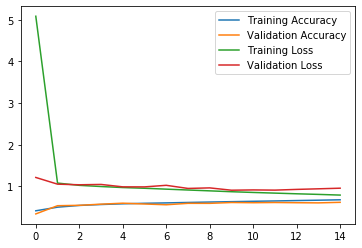

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['Training Accuracy', 'Validation Accuracy', 
            'Training Loss', 'Validation Loss'])

if len(test_set[0])>0:
  report=model.evaluate([test_set[0],test_set[1]],test_set[2])
  print(model.metrics_names[0],report[0])
  print(model.metrics_names[1],report[1])
else:
  print('the test set is empty.')

In [15]:
# download the privacy policies json file
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gssaRcXkhWBWobU1kRIIqpbseQjuVRsU' -O /tmp/privacypolicy.json

--2020-01-04 17:50:51--  https://docs.google.com/uc?export=download&id=1gssaRcXkhWBWobU1kRIIqpbseQjuVRsU
Resolving docs.google.com (docs.google.com)... 74.125.20.139, 74.125.20.101, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ak43nv91i0tnj8a419eh5rru3am4u4pl/1578153600000/05454033152636180987/*/1gssaRcXkhWBWobU1kRIIqpbseQjuVRsU?e=download [following]
--2020-01-04 17:50:51--  https://doc-0c-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ak43nv91i0tnj8a419eh5rru3am4u4pl/1578153600000/05454033152636180987/*/1gssaRcXkhWBWobU1kRIIqpbseQjuVRsU?e=download
Resolving doc-0c-44-docs.googleusercontent.com (doc-0c-44-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-44-docs.googleusercontent.com (doc-0c-44-docs.

In [0]:
pp_text=[]
# adding some test cases
pp_text.append('Test case one, you have no right to withdraw your consent.') 
pp_text.append('Test case two, at any time you can withdraw your consent.')
pp_text.append('Test case three, You can not withdraw your consent any time.')

with open('/tmp/privacypolicy.json') as myfile:
  jdata = json.loads(myfile.read())
  for data in jdata:
    for row in data['data']:
      pp_text.append(row)

print(pp_text)

# GDPR article 7
regulation=['The data subject shall have the right to withdraw his or her consent at any time.']

In [17]:
to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]))

print('Legal statement: \n', regulation[0],'\n')
print('order of outputs:\n contradition, neutral, entailment \n')

for text in pp_text:
  case = [[regulation[0]],[text]]
  reg_pp_test = prepare_data(case)
  result=model.predict([reg_pp_test[0][:],reg_pp_test[1][:]])

  print(case[1][0])
  for v1,v2,v3 in result[:][:]:
      print('Predicted: %.2f' %v1, '%.2f' %v2 ,'%.2f' %v3,'\n')

Legal statement: 
 The data subject shall have the right to withdraw his or her consent at any time. 

order of outputs:
 contradition, neutral, entailment 

Test case one, you have no right to withdraw your consent.
Predicted: 0.54 0.25 0.21 

Test case two, at any time you can withdraw your consent.
Predicted: 0.63 0.16 0.21 

Test case three, You can not withdraw your consent any time.
Predicted: 0.89 0.03 0.08 

If we do, we’ll make sure you can revoke your consent in our services or through your device permissions.
Predicted: 0.04 0.78 0.18 

Your use of the Services is subject to the Terms of Use, Copyright Policy and this Privacy Policy and indicates your consent to them.
Predicted: 0.04 0.11 0.85 

You may also at any time withdraw any consent given, with future effect.
Predicted: 0.01 0.98 0.01 

Withdrawing your consent will not affect the lawfulness of any processing we conducted prior to your withdrawal, nor will it affect the processing of your personal information conduct